In [1]:
import malariagen_data
import allel
import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import re
from os import system

In [2]:

sample_sets = ['1288-VO-UG-DONNELLY-VMF00219', '1231-VO-MULTI-WONDJI-VMF00043', '1240-VO-MZ-KOEKEMOER-VMF00101', '1240-VO-CD-KOEKEMOER-VMF00099',  '1230-VO-GA-CF-AYALA-VMF00045','1236-VO-TZ-OKUMU-VMF00090','1232-VO-KE-OCHOMO-VMF00044']
region = "3RL:67,925,771-67,931,656" #### TMC region
output_filename = 'TMC_cluster_assignments.csv'
sample_query= 'country in ["Uganda","Kenya", "Tanzania", "Democratic Republic of Congo"]'

In [3]:

af1 = malariagen_data.Af1(pre=True,
                          gcs_cache='/home/namulil/lstm_projects/funestus_llineup/gcs_cache',
                          results_cache='home/namulil/lstm_projects/funestus_llineup/results_cache'
                          )
af1

<MalariaGEN Af1 API client>
Storage URL             : gs://vo_afun_release_master_us_central1/
Data releases available : 1.0, 1.1, 1.2, 1.3, 1.4
Results cache           : /home/namulil/lstm_data/funestus_llineup/notebooks/tagging_snps/home/namulil/lstm_projects/funestus_llineup/results_cache
Cohorts analysis        : 20240515
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.0.1
Client location         : England, United Kingdom
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.0.1/Af1.html

In [4]:
meta = af1.sample_metadata(sample_sets = sample_sets)

In [5]:
# Get the haplotypes from the region of interest
haps = af1.haplotypes(
    region = region,
    analysis = 'funestus', 
    sample_sets = sample_sets,
    sample_query= sample_query,
    

)


In [6]:
## acess numpy hap array using the key call_genotype

haparray = allel.GenotypeArray(haps['call_genotype']).to_haplotypes()## we convert the geotype array to haplotypes


# Get allele counts
ac = haparray.count_alleles()## aaray with allele counts rows= counts in samples, columns =sites/ genomic regions 

In [7]:
# Identify segregating non-singletons. 
#non_singleton = ac.min(1) > 1
# Filter the datasets, removing non-segregating and singleton variants 
#haps = haps.isel(variants = np.where(non_singleton)[0])
#haparray = haparray[non_singleton]

hapsamples = np.array(np.repeat(haps['sample_id'], 2))
dist = allel.pairwise_distance(haparray, metric = 'hamming')

site_filter = af1.snp_calls(region=region, sample_sets= sample_sets)['variant_filter_pass_funestus']
n_bases = np.sum(site_filter.values)
dist_dxy = dist * haparray.n_variants / n_bases

z = scipy.cluster.hierarchy.linkage(dist_dxy, method="complete")

In [8]:
def find_clusters(clust, n, threshold=0.001, method='complete'):### how we create and cluster selection sweeps in our samples 

        # find clusters
        f = scipy.cluster.hierarchy.fcluster(clust, threshold,
                                             criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        return clusters

    
focal_clusters = find_clusters(z, n=50, threshold=0.001)

min_cluster_size = 20
large_focal_clusters = [cluster for cluster in focal_clusters if len(cluster) > min_cluster_size]
print(f'There were {len(large_focal_clusters)} clusters larger than {min_cluster_size} haplotypes.')


There were 10 clusters larger than 20 haplotypes.


In [9]:
def assign_sample_haplotypes(cluster_ids):
    cluster_samples = hapsamples[list(cluster_ids)]
    sample_hap_genotype = meta.sample_id.apply(lambda x: np.sum(np.isin(cluster_samples, x)))
    return(sample_hap_genotype)

for i in range(len(large_focal_clusters)):
    meta[f'cluster_{i+1}'] = assign_sample_haplotypes(large_focal_clusters[i])

output_table = meta[['sample_id'] + [f'cluster_{i+1}' for i in range(len(large_focal_clusters))]]

output_table.to_csv(output_filename, sep = '\t', index_label = 'sample_name')

In [10]:
output_table

,sample_id,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,VBS17729,0,0,0,0,0,0,0,0,0,0
1,VBS17730,0,0,0,0,0,0,0,0,0,0
2,VBS17731,0,0,0,0,0,0,0,0,0,0
3,VBS17732,0,0,0,0,0,0,0,0,0,0
4,VBS17733,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1689,VBS67003-6645STDY13057647,1,0,0,0,0,0,0,0,0,0
1690,VBS67004-6645STDY13057648,0,0,0,0,0,0,1,0,0,1
1691,VBS67006-6645STDY13057650,0,0,0,0,0,0,0,0,0,0
1692,VBS67007-6645STDY13057651,1,0,0,0,0,0,0,0,0,0


In [11]:
# Now we want to work out the sequence of each haplotype
window_alleles = pd.concat((
    pd.DataFrame({'Chrom': [haps.contigs[x] for x in haps['variant_contig'].values]}),
    haps['variant_position'].to_pandas().rename('Pos'),
    haps['variant_allele'].astype('str').to_pandas().set_axis(['Ref', 'Alt'], axis = 1)),
    axis = 1
)

remove_rows = np.full(window_alleles.shape[0], True)
for i in range(len(large_focal_clusters)):
    cluster_haparray = haparray[:, list(large_focal_clusters[i])]
    # We want a table that shows, for each position, the ref, the alt, and the number of
    # each in the haplotypes
    n_alt = np.sum(cluster_haparray, axis = 1)
    window_alleles[f'n_Ref_cluster_{i+1}'] = cluster_haparray.shape[1] - n_alt
    window_alleles[f'n_Alt_cluster_{i+1}'] = n_alt
    remove_rows = remove_rows & (n_alt == 0)

non_cluster = set(range(haparray.shape[1])).difference(*large_focal_clusters)
non_cluster_haparray = haparray[:, list(non_cluster)]
n_alt_non_cluster = np.sum(non_cluster_haparray, axis = 1)
window_alleles[f'n_Ref_non_cluster'] = non_cluster_haparray.shape[1] - n_alt_non_cluster
window_alleles[f'n_Alt_non_cluster'] = n_alt_non_cluster

# We want to remove the rows where all clusters are fully Ref.
window_alleles = window_alleles.loc[~remove_rows, :]

haparray_output_filename = re.sub('\.[^.]+$', '_hap_sequence.csv', output_filename)
window_alleles.to_csv(haparray_output_filename, sep = '\t', index = False)



In [12]:
# Some plotting functions
def truspan(cluster, r):
    # get the index of the cluster haps in the dendrogram list of all haps
    cluster_leaves = sorted([r['leaves'].index(i) for i in cluster])
    # are these indices monotonic - they should be!
    x = np.asarray(cluster_leaves)
    dx = np.diff(x)
    mon = np.all(dx == 1)
    assert mon
    return min(cluster_leaves), max(cluster_leaves)

def plot_dendrogram(zhier, ax, h, method='complete', color_threshold=0, above_threshold_color='k'):

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(zhier, no_labels=True, count_sort=True,
                                           color_threshold=color_threshold,
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    #ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-.0001)

    ax.set_ylabel(r'$d_{xy}$')
    ax.autoscale(axis='x', tight=True)
    return r

def draw_hap_cluster_plot(z, h, cluster_labels, vspans,
                          colour_schemes, labels, label_names,
                          add_legend = True, title = '',
                          fn = None):

    gs = GridSpec(len(colour_schemes)+2, 1, height_ratios=[6.0, 0.3] + [0.4]*len(colour_schemes))
    fig = plt.figure(figsize=(15, 7 + 0.58 * len(colour_schemes)))

    plt.subplots_adjust(hspace=0.02)
    ax1 = plt.subplot(gs[0])
    sns.despine(ax=ax1, offset=5, bottom=True, top=True)
    r = plot_dendrogram(z, ax1, h)
    ax1.spines['top'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylim(0)

    if add_legend:
        plot_x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
        plot_y_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
        legend_x = ax1.get_xlim()[0] + plot_x_range * 0.95

    ax_clu = fig.add_subplot(gs[1])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -2 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.7, lbl, va='top', ha='center')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])

    legend_offset = 0
    for i in range(len(colour_schemes)):
        this_ax = fig.add_subplot(gs[i+2])

        l = labels[i].take(r['leaves'])
        hap_clrs = [colour_schemes[i][p] for p in l]
        this_ax.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])],
                            yrange=(0, 1),
                            color=hap_clrs);
        sns.despine(ax=this_ax, offset=5, left=True, bottom=True, top=True)

        this_ax.set_xticks([])
        this_ax.set_yticks([])
        this_ax.set_xlim(0, h.shape[1])
        this_ax.yaxis.set_label_position('left')
        this_ax.set_ylabel(label_names[i], rotation=0, ha='right', va='center')

        if add_legend:       
            unique_label = np.unique(l)
            for j, k in enumerate(unique_label[::-1]):
                legend_y = ax1.get_ylim()[0] + plot_y_range * (0.2 + legend_offset)
                ax1.add_patch(mpl.patches.Rectangle((legend_x,legend_y), plot_x_range/50,plot_y_range/15, color = colour_schemes[i][k]))
                ax1.text(legend_x*1.03,legend_y + plot_y_range / 50, k)
                legend_offset += 0.1
            legend_offset += 0.05



    ax1.set_title(f'{title}')
    ax1.autoscale()
    fig.patch.set_alpha(1)
    
    if fn != None:
        ext = re.sub('.*\.', '', fn)
        plt.savefig(fn, format = ext)





In [13]:
r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True,
        color_threshold=0, no_plot=True,
        above_threshold_color='k')

v_span = [truspan(cluster, r) for cluster in large_focal_clusters]

In [14]:
#hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis = 0))
#hap_meta.columns = meta.columns

In [15]:
###trying to subset meta tho not done with yesterdays run
n_haps = haparray.shape[1]
n_samples = n_haps // 2
meta = meta.iloc[:n_samples].reset_index(drop=True)

In [16]:
hap_meta = pd.DataFrame(np.repeat(meta.values, 2, axis=0), columns=meta.columns)
assert hap_meta.shape[0] == haparray.shape[1], "hap_meta and haparray are still mismatched"


In [17]:
country_colours = {
    'Kenya': 'red', 
    'Tanzania': 'navy', 
    'Uganda': 'lightgreen'
}

mask = hap_meta['country'].isin(country_colours.keys())
hap_meta = hap_meta[mask].reset_index(drop=True)
haparray = haparray[:, mask.values]


In [18]:
## also trying this although I dint need it with yesterday run

import scipy.cluster.hierarchy as sch

z = sch.linkage(haparray.T, method='complete', metric='hamming')

z = sch.linkage(haparray.T, method='complete', metric='hamming')

In [19]:
print(haparray.shape)

(1372, 1772)


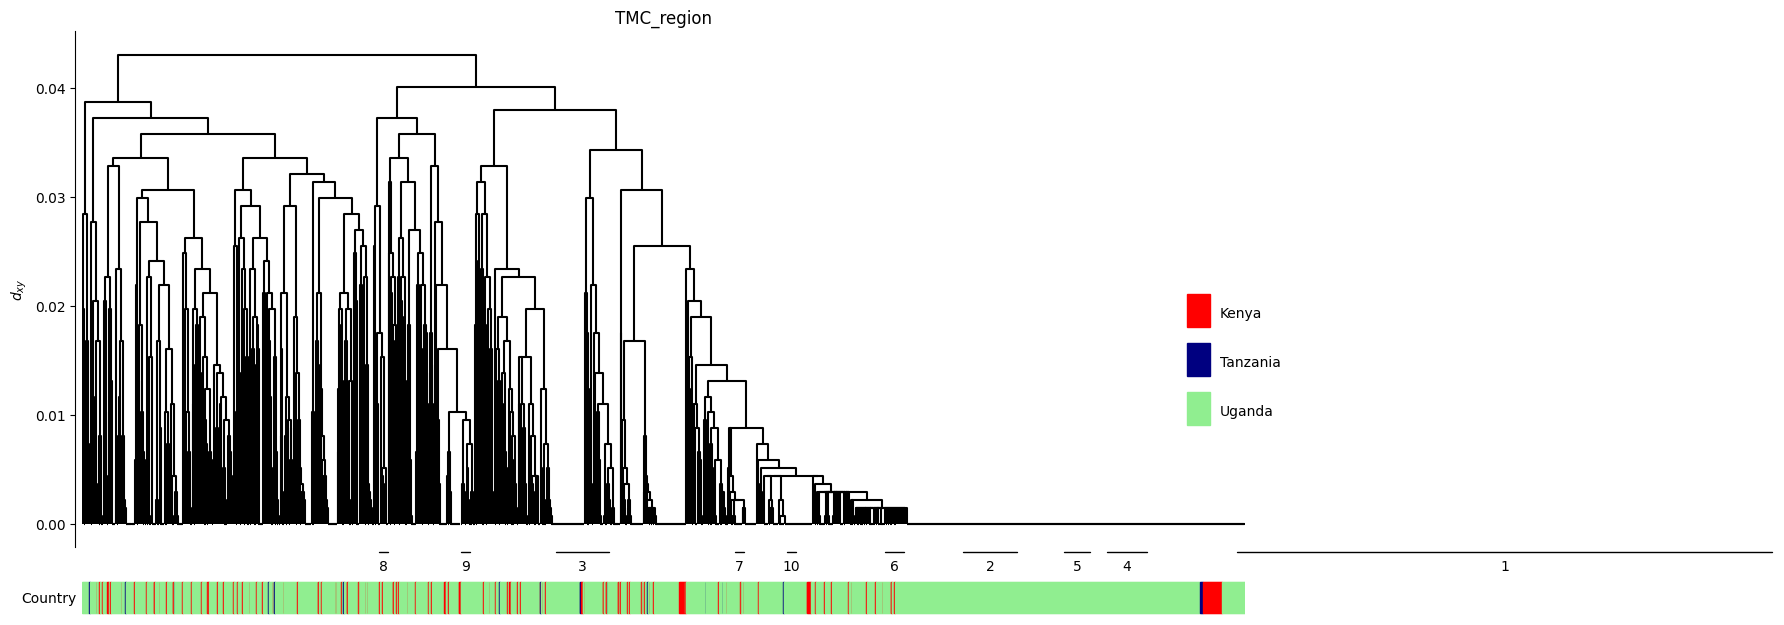

In [20]:
Dup_hap_status = np.array(['Absent', 'Present'])[pd.DataFrame(haparray).apply(np.max, 1)]
draw_hap_cluster_plot(z, haparray, 
                      cluster_labels = range(1, len(large_focal_clusters) + 1), vspans = v_span,
                      colour_schemes = [country_colours],
                      labels = [hap_meta['country']],
                      label_names = ['Country'],
                      title = 'TMC_region',
                      fn = 'TMC_region.svg'
)